# 算法实现

In [1]:
import subprocess
import networkx as nx
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

import utils

In [2]:
FILE_PATH = './data'
CSV_FILE = 'user.csv'

## 1. SynchroTrap 的原理

论文：[Uncovering Large Groups of Active Malicious Accounts in Online Social Networks](https://users.cs.duke.edu/~xwy/publications/SynchroTrap-ccs14.pdf)

SynchroTrap 通过构建 `<U, T, C>` 三元组来衡量用户与用户间的距离。

- U: UID
- T: Time
- C: constraint field

$\left\langle U_i, T_i, C_i\right\rangle \approx\left\langle U_j, T_j, C_j\right\rangle \quad$ if $C_i=C_j$ and $\left|T_i-T_j\right| \leq T_{\text {sim }}$

它的基本思想是：如果两条日志的时间差小于一个较小的 $T_{\text {sim }}$，且限制项 $C_i$ 与 $C_j$ 相等，则认为 $U_i$ 和 $U_j$ 有关联。其中，限制项 $C$ 可以是任何与资源限制有关的项，比如银行卡号、Wi-Fi  SSID、IP、Geohash、fingerprint 等。

任意两个 UID 的相似度可由 Jaccard similarity 计算得出：

$\operatorname{Sim}\left(U_i, U_j\right)=\frac{\left|A_i \cap A_j\right|}{\left|A_i \cup A_j\right|}=\frac{\sum_k\left|A_i^k \cap A_j^k\right|}{\sum_k\left|A_i^k \cup A_j^k\right|}$

## 2. 用 Jaccard 相似度建边

我们需要设定一些超参，包括时间差 `T_sim`、建边阈值 `THRESHOLD` 和 最小匹配记录数 `MIN_CNT`

In [3]:
T_sim = 300  # 单位秒 
THRESHOLD = 0.03
MIN_CNT = 1

In [4]:
# 加载日志数据
csv_path = utils.gen_abspath(directory=FILE_PATH, rel_path=CSV_FILE)
df = utils.read_csv(csv_path)
df

,uid,ipv4,time,timestamp
0,851,98.245.3.124,2024-07-31 11:37:55,1722397075
1,227,253.155.228.78,2024-07-31 11:38:18,1722397098
2,240,3.114.70.213,2024-07-31 11:38:37,1722397117
3,972,32.107.120.156,2024-07-31 11:38:52,1722397132
4,915,254.252.255.168,2024-07-31 11:39:00,1722397140
...,...,...,...,...
2484,503,118.219.88.27,2024-07-31 18:50:19,1722423019
2485,133,125.54.141.195,2024-07-31 18:50:29,1722423029
2486,425,157.168.234.253,2024-07-31 18:50:37,1722423037
2487,183,53.120.190.145,2024-07-31 18:50:42,1722423042


In [5]:
# 创建 SparkSession
spark = SparkSession.builder \
    .appName("App") \
    .getOrCreate()

# 将 Pandas DataFrame 加载进 Spark DataFrame
spark_df = spark.createDataFrame(df)
spark_df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/31 03:44:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+---------------+-------------------+----------+
|uid|           ipv4|               time| timestamp|
+---+---------------+-------------------+----------+
|851|   98.245.3.124|2024-07-31 11:37:55|1722397075|
|227| 253.155.228.78|2024-07-31 11:38:18|1722397098|
|240|   3.114.70.213|2024-07-31 11:38:37|1722397117|
|972| 32.107.120.156|2024-07-31 11:38:52|1722397132|
|915|254.252.255.168|2024-07-31 11:39:00|1722397140|
|796| 77.251.132.154|2024-07-31 11:39:20|1722397160|
| 89|  25.198.85.194|2024-07-31 11:39:41|1722397181|
| 72|  132.109.43.18|2024-07-31 11:39:44|1722397184|
|811|    244.3.65.90|2024-07-31 11:39:49|1722397189|
|466|  51.150.243.71|2024-07-31 11:40:05|1722397205|
|886| 160.71.238.116|2024-07-31 11:40:17|1722397217|
|498|     95.3.44.81|2024-07-31 11:40:38|1722397238|
|132| 217.89.155.157|2024-07-31 11:40:55|1722397255|
|273|    88.44.2.212|2024-07-31 11:40:59|1722397259|
|225|  51.202.40.204|2024-07-31 11:41:06|1722397266|
|454|   93.23.218.76|2024-07-31 11:41:07|17223

In [6]:
# 获取时间差小于 T_sim 的所有 UID pairs
# 计算这些 UID pairs 的 Jaccard similarity
spark_df.createOrReplaceTempView("user_table")

cmd = f"""
SELECT
    uid_a,
    uid_b,
    sum(if(ip_a=ip_b, 1, 0)) as ip_same_cnt,
    count(*) as cnt,
    round(sum(if(ip_a=ip_b, 1, 0)) / count(*), 3) as jaccard_sim
FROM
(
    SELECT
        a.uid as uid_a,
        b.uid as uid_b,
        a.ipv4 as ip_a,
        b.ipv4 as ip_b
    FROM
        user_table a
    JOIN
        user_table b ON a.uid < b.uid
        AND b.timestamp - a.timestamp <= {T_sim}
        AND b.timestamp - a.timestamp >= -{T_sim}
) t
GROUP BY uid_a, uid_b
HAVING jaccard_sim > {THRESHOLD}
    AND cnt > {MIN_CNT}
"""

sim = spark.sql(cmd)

In [7]:
# 符合条件的边
sim.show()

24/07/31 03:44:29 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----+-----+-----------+---+-----------+
|uid_a|uid_b|ip_same_cnt|cnt|jaccard_sim|
+-----+-----+-----------+---+-----------+
|  -16|   -9|          2| 22|      0.091|
|  -32|  -19|          1|  6|      0.167|
|  -13|   -6|          1| 32|      0.031|
|  -14|   -7|          1| 31|      0.032|
|  -17|  -15|          2| 21|      0.095|
|  -34|  -33|          1|  5|        0.2|
|  -12|   -9|          2| 56|      0.036|
|  -32|   -4|          1| 11|      0.091|
|  -35|   -7|          1|  7|      0.143|
|  -20|   -3|          1| 20|       0.05|
|   -9|   -3|          2| 46|      0.043|
|  -34|  -12|          1|  9|      0.111|
|  -35|  -10|          1| 10|        0.1|
|  -16|  -13|          1| 28|      0.036|
|  -16|   -4|          1| 20|       0.05|
|  -17|   -7|          1| 17|      0.059|
|  -31|  -30|          1|  4|       0.25|
|  -32|  -31|          1|  4|       0.25|
|  -10|   -4|          2| 42|      0.048|
|  -16|  -15|          1| 25|       0.04|
+-----+-----+-----------+---+-----

In [8]:
# 边数
sim.count()

142

In [9]:
# uid_a 是否对应多个 uid_b
sim.groupBy(col('uid_a')).agg(count(col('uid_b')).alias('uid_b_cnt')).filter(col('uid_b_cnt') > 1).show()

+-----+---------+
|uid_a|uid_b_cnt|
+-----+---------+
|  -30|        2|
|  -35|        4|
|  -25|        4|
|  -13|        3|
|  -26|        3|
|  -15|        4|
|  -24|        7|
|  -36|        4|
|  -16|        9|
|  -18|        3|
|  -19|        2|
|  -27|        3|
|  -17|        9|
|  -46|        2|
|  -39|        2|
|  -14|        4|
|   -8|        2|
|  -33|        3|
|  -37|        4|
|  -12|        4|
+-----+---------+
only showing top 20 rows



In [10]:
# uid_b 是否对应多个 uid_a
sim.groupBy(col('uid_b')).agg(count(col('uid_a')).alias('uid_a_cnt')).filter(col('uid_a_cnt') > 1).show()

+-----+---------+
|uid_b|uid_a_cnt|
+-----+---------+
|   -3|       10|
|   -7|        9|
|  -13|        7|
|  -15|        6|
|  -16|        4|
|  -19|        4|
|   -2|        9|
|   -6|        8|
|   -8|        4|
|  -14|        3|
|  -12|        6|
|   -4|        9|
|  -10|        7|
|   -9|        8|
|  -11|        8|
|   -1|        6|
|   -5|        3|
+-----+---------+



## 3. 可视化

In [11]:
# 将 Spark DataFrame 转成 Pandas DataFrame
edge_df = sim[['uid_a', 'uid_b']].toPandas()

# 将 DataFrame 转成 List[Tuple]
edgelist = [(row['uid_a'], row['uid_b']) for _, row in edge_df.iterrows()]

# 建图
G = nx.Graph(edgelist)
# G.edges

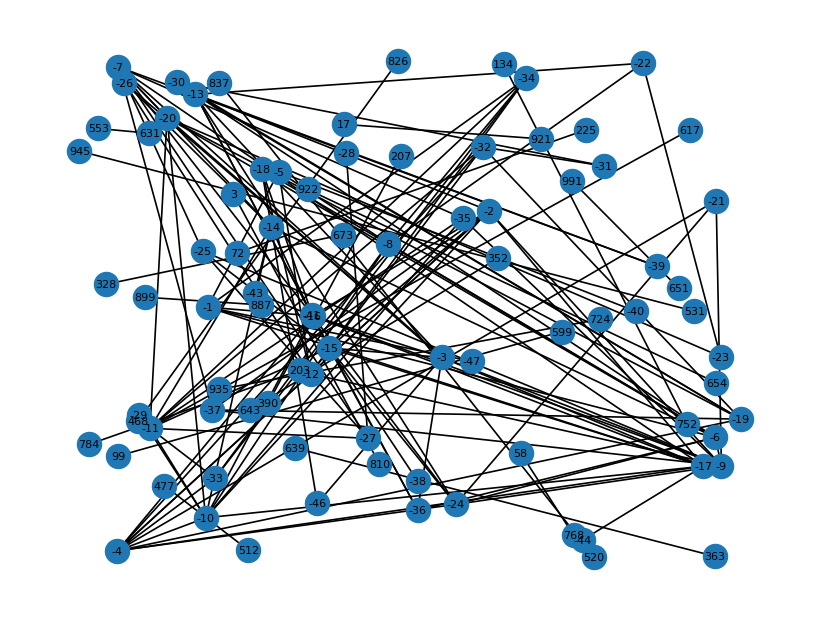

In [12]:
options = {
    'node_size': 300,
    'font_size': 8,
    'width': 1.2,
    'with_labels': True
}

plt.figure(figsize=(8, 6))
nx.draw_random(G, **options)

## 4. 计算强连通图

计算点和边，然后用 `spark-submit` 提交 Spark 任务。

In [13]:
# 获取点
vertices = sim.select(col("uid_a")) \
    .withColumnRenamed("uid_a", "id") \
    .union(sim.select(col("uid_b")) \
           .withColumnRenamed("uid_b", "id")) \
    .distinct()

vertices.show(5)

+---+
| id|
+---+
|-30|
|-35|
|724|
|-25|
| -7|
+---+
only showing top 5 rows



In [14]:
# 点数
vertices.count()

86

In [15]:
# 获取边
edge1 = sim.select([col("uid_a"), col("uid_b")]) \
    .withColumnRenamed("uid_a", "src") \
    .withColumnRenamed("uid_b", "dst")

edge2 = sim.select([col("uid_b"), col("uid_a")]) \
    .withColumnRenamed("uid_b", "src") \
    .withColumnRenamed("uid_a", "dst")

edges = edge1.union(edge2)

edges.show(50)

+---+---+
|src|dst|
+---+---+
|-16| -9|
|-32|-19|
|-13| -6|
|-14| -7|
|-17|-15|
|-34|-33|
|-12| -9|
|-32| -4|
|-35| -7|
|-20| -3|
| -9| -3|
|-34|-12|
|-35|-10|
|-16|-13|
|-16| -4|
|-17| -7|
|-31|-30|
|-32|-31|
|-10| -4|
|-16|-15|
|-12| -5|
| -9| -2|
|-15|-13|
|-32|-11|
|-13| -2|
|-17| -2|
| -6| -1|
|-19| -4|
|-17|-16|
| -9| -6|
|-15| -2|
|-16| -7|
| -4| -2|
|-17| -4|
|-12| -4|
|203|784|
|-30|-13|
|-33| -4|
|-33| -8|
|-18| -6|
| -8| -6|
|-20| -7|
|-20|-10|
|-20|-19|
| -8| -5|
|-18|-12|
|-13| -3|
| 72|225|
|-15| -3|
|-11|617|
+---+---+
only showing top 50 rows



In [16]:
# 边数
edges.count()

284

用 `graphframes` 计算强连通图，计算结果在：`./data/component/`

In [17]:
command = 'cd ./community && sh ./task.sh'
res = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
# res